In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import scipy.sparse as sp
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# I. Abstract

Computational linear algebra is fundamental in data science domains such as  machine learning and text parsing. In the digital age, it's integral to identify trustworthy information and advanced mathematical techniques enable us to do so with confidence. Using the Fake News COVID-19 dataset from Kaggle, we create a binary classification model that labels article headlines as real or fake news. We design a C-TF-IDF classification that employs numerical linear algebra techniques for dimensionality reduction and clustering covered in MA544. In this notebook, we cover the techniques employed, the mathematical principles and logic behind our model, results, and greater implications of this work.

# II. Preprocessing & EDA

Preprocessing involves standardizing the text to be lowercase and only contain alpabetical characters. Lemmatize all words in each article headline that's longer than two characters, isn't a stop word, and doesn't contain a digit.

In [9]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z\s]","",text.lower()).split()
    return text

def flatten(t):
    return [item for sublist in t for item in sublist]


In [3]:
vec = CountVectorizer()
wordnet_lemmatizer = WordNetLemmatizer()

In [4]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vS8iYyoEs7vX9JVXc_irievVS4EVnQa-a-at0cW5fjkOmygYA2q7tua0XgTj_FimEngnqGx7UNHvhI_/pub?gid=830271379&single=true&output=csv")
df['filtered_headlines'] = df['headlines'].apply(preprocess_text)
df['filtered_headlines_without_stopwords'] = df['filtered_headlines'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x \
                                                                if (len(y)>2 and y not in stopwords.words() and y.isdigit()==False)])

In [11]:
tf_mat_fake = flatten([word for word in df[df['outcome'] == 0]['filtered_headlines_without_stopwords']])
tf_mat_fake_cnt = pd.DataFrame(tf_mat_fake).value_counts()

tf_mat_real = flatten([word for word in df[df['outcome'] == 1]['filtered_headlines_without_stopwords']])
tf_mat_real_cnt = pd.DataFrame(tf_mat_real).value_counts()

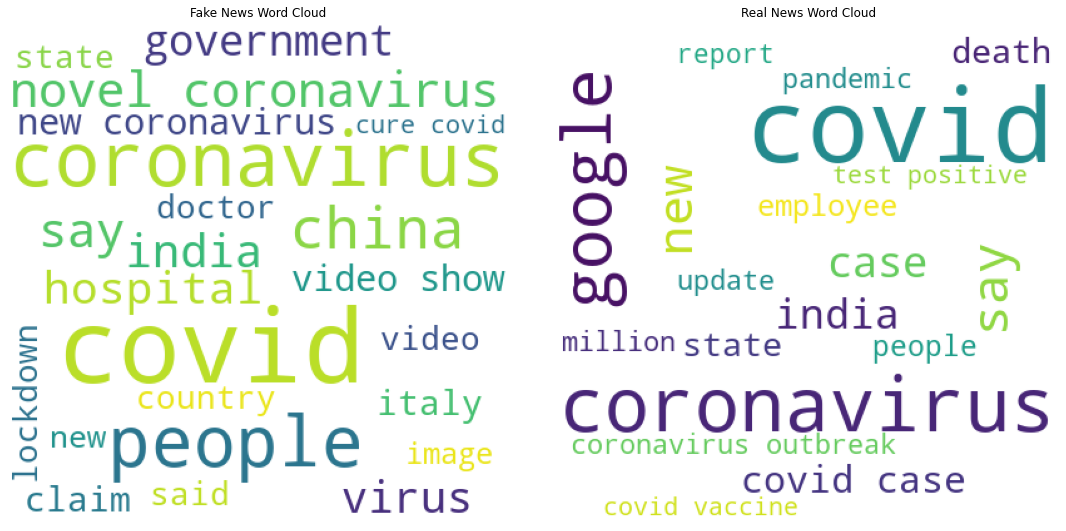

In [13]:
wordcloud_fake = WordCloud(width = 400, height = 400,
                background_color ='white',
                min_font_size = 20).generate(' '.join(tf_mat_fake))

wordcloud_real = WordCloud(width = 400, height = 400,
                background_color ='white',
                min_font_size = 20).generate(' '.join(tf_mat_real))

fig, ax = plt.subplots(1, 2, figsize = (16, 32))

ax[0].imshow(wordcloud_fake)
ax[0].axis("off")
ax[0].set_title("Fake News Word Cloud")
ax[1].imshow(wordcloud_real)
ax[1].axis("off")
ax[1].set_title("Real News Word Cloud")
plt.tight_layout(pad = 5)
 
plt.show()

In [36]:
terms_in_real_headlines = set(tf_mat_real_cnt.index.get_level_values(0))
terms_in_fake_headlines = set(tf_mat_fake_cnt.index.get_level_values(0))
terms_unique_to_real_headlines = (terms_in_real_headlines - terms_in_fake_headlines)
terms_unique_to_fake_headlines = (terms_in_fake_headlines - terms_in_real_headlines)

terms_in_both = terms_in_fake_headlines - terms_unique_to_fake_headlines

In [61]:
tf_real_cnt_df = pd.DataFrame(tf_mat_real_cnt)
tf_real_cnt_df['term'] = tf_real_cnt_df.index.get_level_values(0)
tf_real_cnt_df = tf_real_cnt_df.reset_index(drop=True)

tf_fake_cnt_df = pd.DataFrame(tf_mat_fake_cnt)
tf_fake_cnt_df['term'] = tf_fake_cnt_df.index.get_level_values(0)
tf_fake_cnt_df = tf_fake_cnt_df.reset_index(drop=True)

tf_cnt_df = pd.merge(tf_fake_cnt_df, tf_real_cnt_df, on='term',how='outer')
tf_cnt_df.rename(columns= {'0_x':'fake_count', '0_y':'real_count'},inplace=True)
tf_cnt_df_common_terms = tf_cnt_df.loc[tf_cnt_df.apply(lambda x: pd.isna(x['fake_count'])==False and pd.isna(x['real_count'])==False,axis=1),:].reset_index(drop=True)
tf_cnt_df_common_terms

In [103]:
tf_cnt_df_common_terms.loc[tf_cnt_df_common_terms.apply(lambda x: x['fake_count']>1 and x['real_count']>1,axis=1),:].reset_index(drop=True)

,fake_count,term,real_count
0,3609.0,coronavirus,168.0
1,3072.0,covid,235.0
2,1065.0,video,2.0
3,943.0,people,19.0
4,865.0,claim,5.0
...,...,...,...
577,2.0,mostly,2.0
578,2.0,medicare,2.0
579,2.0,loan,2.0
580,2.0,mohammad,2.0


In [85]:
tf_cnt_df_common_terms[tf_cnt_df_common_terms['term']=='kolkata']['fake_count'].values[0]>1

False

# III. Methodology

In [7]:
class CTFIDFVectorizer(TfidfTransformer):
    def __init__(self, *args, **kwargs):
        super(CTFIDFVectorizer, self).__init__(*args, **kwargs)

    def fit(self, X: sp.csr_matrix, n_samples: int):
        """Learn the idf vector (global term weights) """
        _, n_features = X.shape
        df = np.squeeze(np.asarray(X.sum(axis=0)))
        idf = np.log(n_samples / df)
        self._idf_diag = sp.diags(idf, offsets=0,
                                  shape=(n_features, n_features),
                                  format='csr',
                                  dtype=np.float64)
        return self

    def transform(self, X: sp.csr_matrix) -> sp.csr_matrix:
        """Transform a count-based matrix to c-TF-IDF """
        X = X * self._idf_diag
        X = normalize(X, axis=1, norm='l1', copy=False)
        return X

# IV. Modeling & Analysis

In [104]:
X = vec.fit_transform([" ".join(x) for x in df['filtered_headlines_without_stopwords']])
term_matrix = pd.DataFrame(X.toarray(),columns = vec.get_feature_names())

In [105]:
# Create documents per label
df['cleaned_headlines'] = df['filtered_headlines_without_stopwords'].apply(lambda x: ' '.join(x))
docs = pd.DataFrame({'Document': df.cleaned_headlines, 'Class': df.outcome})
docs_per_class = df.groupby(['outcome'], as_index=False).agg({'cleaned_headlines': ' '.join})


# Create c-TF-IDF
count = CountVectorizer().fit_transform(docs_per_class.cleaned_headlines)
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs))

In [106]:
# Create bag of words
count_vectorizer = CountVectorizer().fit(docs_per_class.cleaned_headlines)
count = count_vectorizer.transform(docs_per_class.cleaned_headlines)
words = count_vectorizer.get_feature_names()

# Extract top 10 words per class
ctfidf = CTFIDFVectorizer().fit_transform(count, n_samples=len(docs)).toarray()
words_per_class = {label: [words[index] for index in ctfidf[label].argsort()[-10:]] 
                   for label in docs_per_class.outcome}

## Informative Words per Class

In [118]:
top_words = pd.DataFrame(words_per_class)
top_words.rename(columns={0:'Fake Headlines', 1:'Real Headlines'},inplace=True)

In [120]:
top_words

,Fake Headlines,Real Headlines
0,pandemic,death
1,new,india
2,post,test
3,lockdown,new
4,show,update
5,claim,coronavirus
6,people,say
7,video,case
8,covid,covid
9,coronavirus,google


## Article Classification

In [121]:
train_test_split = np.ones(len(df))
train_test_split[:int(len(df)/6)] = 0
np.random.shuffle(train_test_split)

In [122]:
df['split'] = train_test_split
docs_per_class_train = df[df['split'] == 1].groupby(['outcome'], as_index=False).agg({'cleaned_headlines': ' '.join})
docs_per_class_test = df[df['split'] == 0].groupby(['outcome'], as_index=False).agg({'cleaned_headlines': ' '.join})

In [123]:
count_vectorizer = CountVectorizer().fit(docs_per_class.cleaned_headlines)
count = count_vectorizer.transform(docs_per_class.cleaned_headlines)
ctfidf_vectorizer = CTFIDFVectorizer().fit(count, n_samples=len(df))
ctfidf = ctfidf_vectorizer.transform(count)

count = count_vectorizer.transform(df[df['split'] == 0]['cleaned_headlines'])
vector = ctfidf_vectorizer.transform(count)

The F1-score of the model correctly labeling fake news headlines indicates a strong performance. A middle-of-the-road F1-score on real news headlines requires closer evaluation. While a high recall score indicates that the classifer performs well at classifying all of the reliable news headlines, the subpar precision score indicates that the model is oversensitive and mistakenly classifies fakes news headlines as real.  

In [124]:
distances = cosine_similarity(vector, ctfidf)
prediction = np.argmax(distances, 1)

print(metrics.classification_report(df[df['split'] == 0].outcome, prediction))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1614
           1       0.49      0.87      0.62        86

    accuracy                           0.95      1700
   macro avg       0.74      0.91      0.80      1700
weighted avg       0.97      0.95      0.95      1700



# V. Discussion of Results

A classification model of this capacity can be used for numerous purposes. Two particular use cases that come to mind include identifying the hallmark words of each class and predicting the veracity of an article based off its headline.